In [1]:
#FUNÇÃO PARA LIMPAR RESULTADOS
import numpy as np

def clear_results(valores, tol=1e-5):
    valores = np.array(valores)
    valores[np.abs(valores) < tol] = 0
    return valores

In [2]:
#CINEMÁTICA DIRETA SIMBÓLICA

#importar bibliotecas necessárias
from roboticstoolbox import ET, ERobot
import numpy as np
from spatialmath import SE3
import sympy as sp

#definindo o braço do robô

#parâmetros do braço
a2 = 0.6 
a3 = 0.2
rot = np.pi/6

e = ET.tz(qlim=[0, 0.170]) * ET.tz(0.300) * ET.Rz(qlim=[-np.pi, np.pi]) * ET.tx(a2) * ET.tx(a3) * ET.Rx(qlim=[-np.pi, np.pi]) * ET.Ry(rot) * ET.tz(-0.100) * ET.tx(0.100) * ET.tz(0.100)

#Transformação do braço num objeto ERobot
cookbot = ERobot(e)
print(cookbot)

#variáveis simbólicas
q1, q2, q3 = sp.symbols('q1 q2 q3')
pos_sim = (q1, q2, q3)

#definindo a cinemática direta simbólica
TE = cookbot.fkine([q1, q2, q3])
print("A cinemática direta simbólica é:")
print(TE)

#posição do end-effector
print("A posição do end-effector é:")
print(TE.t)


ERobot: , 3 joints (PRR)
┌──────┬────────┬───────┬────────┬────────────────────────────────────────┐
│ link │  link  │ joint │ parent │          ETS: parent to link           │
├──────┼────────┼───────┼────────┼────────────────────────────────────────┤
│    0 │ link0  │     0 │ BASE   │ tz(q0)                                 │
│    1 │ link1  │     1 │ link0  │ tz(0.3) ⊕ Rz(q1)                       │
│    2 │ link2  │     2 │ link1  │ tx(0.6) ⊕ tx(0.2) ⊕ Rx(q2)             │
│    3 │ @link3 │       │ link2  │ Ry(30°) ⊕ tz(-0.1) ⊕ tx(0.1) ⊕ tz(0.1) │
└──────┴────────┴───────┴────────┴────────────────────────────────────────┘

A cinemática direta simbólica é:
  -0.5*sin(q2)*sin(q3) + 0.866025403784439*cos(q2) -1.0*sin(q2)*cos(q3) 0.866025403784439*sin(q2)*sin(q3) + 0.5*cos(q2) -0.05*sin(q2)*sin(q3) + 0.886602540378444*cos(q2)  
  0.866025403784439*sin(q2) + 0.5*sin(q3)*cos(q2) 1.0*cos(q2)*cos(q3) 0.5*sin(q2) - 0.866025403784439*sin(q3)*cos(q2) 0.886602540378444*sin(q2) + 0.05*sin(q3)*co

In [3]:
#CINEMÁTICA INVERSA NUMÉRICA

#supondo um valor de posição final e inicial
pos_inicial = (0.9, 0, 0.300)
pos_inicial = SE3(pos_inicial)

pos_final = SE3(0.0, 0.9, 0.46) * SE3.RPY([180, 0, 90], order='zyx', unit='deg')
print(pos_final)
#cinemática inversa numérica
sol1 = cookbot.ikine_LM(pos_inicial)
sol2 = cookbot.ikine_LM(pos_final)
if sol1.success == True:
    print("A solução numérica da cinemática inversa para posição inicial é:")
    print(clear_results(sol1.q))
else:
    print("Não foi possível encontrar uma solução numérica para a posição inicial.")

if sol2.success == True:
    print("A solução numérica da cinemática inversa para posição final é:")
    print(clear_results(sol2.q))
else:
    print("Não foi possível encontrar uma solução numérica para a posição final.")



   0         1         0         0         
   1         0         0         0.9       
   0         0        -1         0.46      
   0         0         0         1         

Não foi possível encontrar uma solução numérica para a posição inicial.
Não foi possível encontrar uma solução numérica para a posição final.


In [4]:
from roboticstoolbox import mstraj

#INTERVALOS DE TEMPO


#TRAJETÓRIAS
#batatas serão despejadas na bandeja
POS0 = cookbot.fkine([0, 0, 0])
print("A posição inicial do end-effector é:", POS0.t)
#posição 1: batatas acima da fritadeira
POS1 = cookbot.fkine([0.17, np.pi/2, 0])
print("A posição  do end-effector na posição 1 é:", POS1.t)
#posição 2: batatas  dentro da fritadeira
POS2 = cookbot.fkine([0, np.pi/2, 0])
print("A posição  do end-effector na posição 2 é:", POS2.t)
#posição 3: retirar as batatas da fritadeira
POS3 = POS1
print("A posição  do end-effector na posição 3 é:", POS3.t)
#posição 4: levar as batatas até a bandeja de despejo
POS4 = cookbot.fkine([0.17, np.pi, 0])
print("A posição  do end-effector na posição 4 é:", POS4.t)
#posição 5: despejar as batatas na bandeja
POS5 = cookbot.fkine([0.17, np.pi, np.pi])
print("A posição  do end-effector na posição 5 é:", POS5.t)


#Crinado um vetor com as posições
viapoints = np.array([
    [0, 0, 0],                       # POS0
    [0.17, np.pi/2, 0],              # POS1
    [0, np.pi/2, 0],                 # POS2
    [0.17, np.pi/2, 0],              # POS3
    [0.17, np.pi, 0],                # POS4
    [0.17, np.pi, np.pi],            # POS5
])

#vetor com os tempos de cada segmento
tsegment = np.array([5,         # Tempo para ir de POS0 a POS1                    
                     8,         # Tempo para ir de POS1 a POS2  
                     8,         # Tempo para ir de POS2 a POS3
                     6,         # Tempo para ir de POS3 a POS4
                     5])        # Tempo para ir de POS4 a POS5

traj_final = mstraj(
    viapoints=viapoints, 
    dt=0.04, 
    tacc=2, 
    tsegment = tsegment
)



A posição inicial do end-effector é: [0.88660254 0.         0.25      ]
A posição  do end-effector na posição 1 é: [5.42887482e-17 8.86602540e-01 4.20000000e-01]
A posição  do end-effector na posição 2 é: [5.42887482e-17 8.86602540e-01 2.50000000e-01]
A posição  do end-effector na posição 3 é: [5.42887482e-17 8.86602540e-01 4.20000000e-01]
A posição  do end-effector na posição 4 é: [-8.86602540e-01  1.08577496e-16  4.20000000e-01]
A posição  do end-effector na posição 5 é: [-8.86602540e-01  1.02454262e-16  5.20000000e-01]


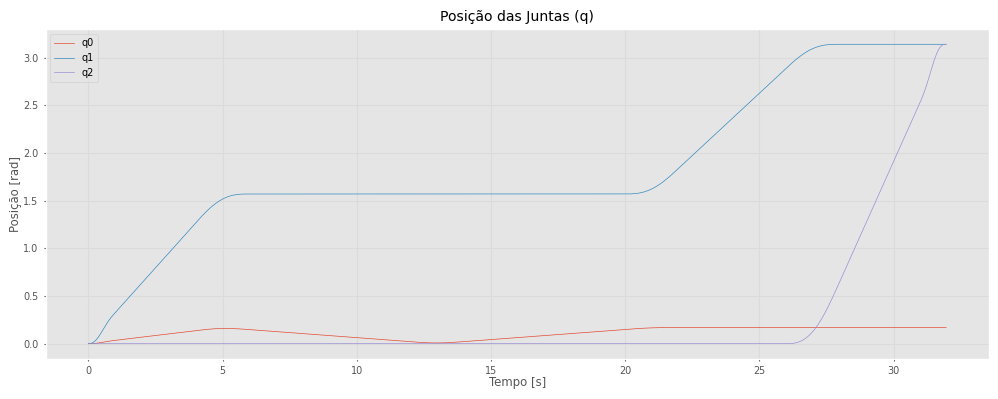

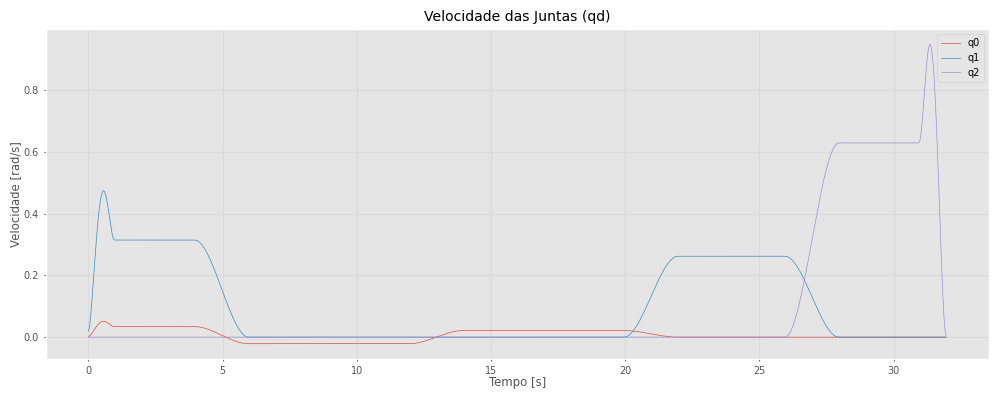

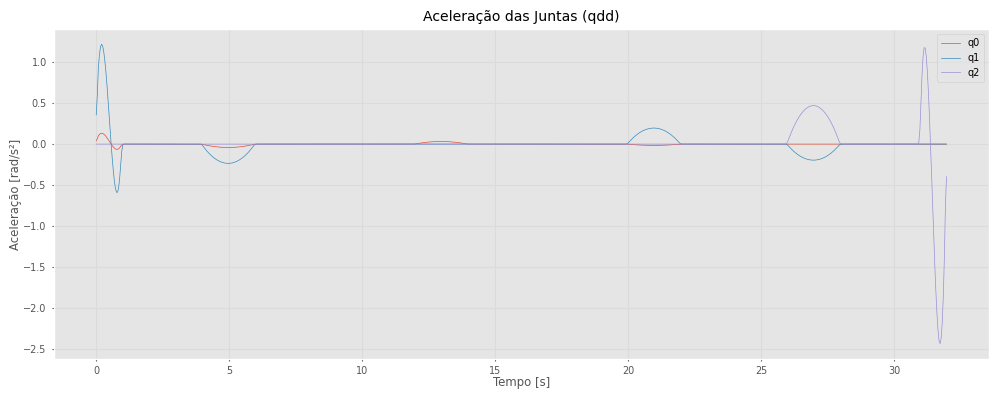

In [5]:
#VELOCIDADE E ACELERAÇÃO DAS JUNTAS
import matplotlib.pyplot as plt
import numpy as np

q = traj_final.q      # Posições articulares, shape=(N, n_juntas)
t = traj_final.t      # Vetor de tempo, shape=(N,)

# Derivada numérica para obter velocidade
qd = np.gradient(q, t, axis=0)

# Derivada numérica para obter aceleração
qdd = np.gradient(qd, t, axis=0)

# Derivada numérica para obter velocidades e acelerações
qd = np.gradient(q, t, axis=0)
qdd = np.gradient(qd, t, axis=0)

# Plot das posições (q)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, q[:, i], label=f'q{i}')
plt.title('Posição das Juntas (q)')
plt.xlabel('Tempo [s]')
plt.ylabel('Posição [rad]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot das velocidades (qd)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, qd[:, i], label=f'q{i}')
plt.title('Velocidade das Juntas (qd)')
plt.xlabel('Tempo [s]')
plt.ylabel('Velocidade [rad/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot das acelerações (qdd)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, qdd[:, i], label=f'q{i}')
plt.title('Aceleração das Juntas (qdd)')
plt.xlabel('Tempo [s]')
plt.ylabel('Aceleração [rad/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#JACOBIANO E ANALISE DE SINGULARIDADE
from roboticstoolbox import jsingu
import sympy as simpy


#componente translacional do end-effector
p = TE.t

#definindo as variáveis simbólicas para o jacobiano
q = pos_sim

#definindo o jacobiano simbólico
J = simpy.Matrix(p).jacobian(q)
print("O Jacobiano simbólico é:")
print(J)
print(simpy.Matrix.rank(J))
print("O Determinante do Jacobiano é:", J.det())

O Jacobiano simbólico é:
Matrix([[0, -0.886602540378444*sin(q2) - 0.05*sin(q3)*cos(q2), -0.05*sin(q2)*cos(q3)], [0, -0.05*sin(q2)*sin(q3) + 0.886602540378444*cos(q2), 0.05*cos(q2)*cos(q3)], [1.00000000000000, 0, 0.05*sin(q3)]])
3
O Determinante do Jacobiano é: -0.0025*sin(q2)**2*sin(q3)*cos(q3) - 0.0025*sin(q3)*cos(q2)**2*cos(q3)
